In [1]:
# Download packages
!pip install plotly
!pip install stopwordsiso
!pip install yellowbrick
!pip install imblearn

# Libraries used to load dataframe and visualize data
import numpy as np 
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.features import RadViz
from wordcloud import WordCloud
import plotly.io as pio
pio.renderers.default='notebook'
%matplotlib inline

# Noise removal helper libraries
import re
import string 
from stopwordsiso import stopwords as sw
from nltk.corpus import stopwords

# Text Preprocessing
from nltk.tokenize import TweetTokenizer
from nltk import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Feature Engineering and Data preparation for modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Model building and training
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#Model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

#save the final model and vectorizer
import pickle

In [2]:
# Load the training dataset
train = pd.read_csv(r"train.csv")

# Display the first 10 rows training dataset dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                                                                                                    message  \
0              PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable   
1                                                                                            It's not like we lack evidence of anthropogenic global warming   
2              RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…   
3                                                       #TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD   
4                                RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight   
5                                            Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j   
6                                   RT @thenation: Mike Pence doesn’t believe in global warming or that smoking causes lung cancer. https://t.co/gvWYaauU8R   
7  RT @makeandmendlife: Six big things we can ALL do today to fight climate change, or how to be a climate activistÃ¢â‚¬Â¦ https://t.co/TYMLu6DbNM hÃ¢â‚¬Â¦   
8               @AceofSpadesHQ My 8yo nephew is inconsolable. He wants to die of old age like me, but will perish in the fiery hellscape of climate change.   
9                                                                  RT @paigetweedy: no offense… but like… how do you just not believe… in global warming………   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [3]:
# Load the testing dataset
test = pd.read_csv(r"test_with_no_labels.csv")

# Display the first 10 rows testing dataset dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(test.head(10))

message  \
0                         Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq   
1              Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj   
2       The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..   
3       @Karoli @morgfair @OsborneInk @dailykos \nPutin got to you too Jill ! \nTrump doesn't believe in climate change at all \nThinks it's s hoax   
4                                                                  RT @FakeWillMoore: 'Female orgasms cause global warming!'\n-Sarcastic Republican   
5  RT @nycjim: Trump muzzles employees of several gov’t agencies in effort to suppress info on #climate change &amp; the environment. https://t.co…   
6      @bmastenbrook yes wrote that in 3rd yr Comp Sci ethics part. Was told by climate change denying Lecturer that I was wrong &amp; marked down.   
7                      RT @climatehawk1: Indonesian farmers weather #climate change w/ conservation agriculture | @IPSNews https://t.co/1NZUCCMlYr…   
8                                 RT @guardian: British scientists face a ‘huge hit’ if the US cuts climate change research https://t.co/KlKQnYDXzh   
9           Aid For Agriculture | Sustainable agriculture and climate change adaptation for small-scale farmers https://t.co/q7IPCP59x9 via @aid4ag   

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

In [4]:
# Create dataframe cleaning function
def text_preprocessing (df):
    
    """This function removes noise from a dataframe containing text data.  It removes url addresses, all instances of numerical
       values, twitter handles (in the form '@handle'), as well as all occurences of non-ascii characters, all using predefined
       regex patterns from the re library.  It also removes punctuation,  using the `punctuation` method from the string library, and finally, it 
       changes all the text data into lowercase form
       
       Parameters
       ----------
       df : <class 'pandas.core.frame.DataFrame'>
           The dataframe with text data that to be cleared of noise
           
       Returns
       -------
       Pandas DataFrame : <class 'pandas.core.frame.DataFrame'>
           A clean dataframe that has been cleared of noise
       """
    
    # Regex pattern for url addresses
    pattern_url = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)' 
    
    # Regex patter for numerical values
    pattern_digits = r'\d+'
    
    # Regex pattern for twitter handles
    pattern_handles = r'@(\w+)'
    
    # Create a copy of the original dataframe to perform cleaning on
    df = df.copy()
    
    # Use the url regex pattern  to remove website addresses
    df['message'] = df['message'].replace(to_replace = pattern_url, value = '', regex = True)
    
    # Use numerical values regex pattern to remove digits 
    df['message'] = df['message'].replace(to_replace = pattern_digits, value = '', regex = True)
    
    # Use the twitter handle regex pattern to remove handles
    df['message'] = df['message'].replace(to_replace = pattern_handles, value = '', regex = True)
    
    # Create a function low that converts text to lowercase
    low = lambda tweets: ''.join([tweet.lower() for tweet in tweets])
    df['message'] = df['message'].apply(low) # The low function is used convert values in the message column to lowercase
    
    # Create a function punct that removes punctuation from a dataframe
    punct = lambda tweets: ''.join([tweet for tweet in tweets if tweet not in string.punctuation])
    df['message'] = df['message'].apply(punct)# The punct function is used ot remove punctuation from the message column
    
    # Use a regex pattern to remove non-ascii characters from the message column in the dataframe
    df.message.replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)
    
    #return the final dataframe object which has undergone noise removal
    return df

In [5]:
# Call dataframe cleaning function with the testing dataset as input, creating a new, clean training dataset dataframe
clean_train = text_preprocessing(train)

# Display the first 10 row of the clean training dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(clean_train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                                                                     message  \
0                     polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what  via    
1                                                              its not like we lack evidence of anthropogenic global warming   
2                                     rt  researchers say we have three years to act on climate change before its too late     
3                                                      todayinmaker wired   was a pivotal year in the war on climate change    
4                            rt  its  and a racist sexist climate change denying bigot is leading in the polls electionnight   
5                                                            worth a read whether you do or dont believe in climate change     
6                                        rt  mike pence doesnt believe in global warming or that smoking causes lung cancer    
7                          rt  six big things we can all do today to fight climate change or how to be a climate activist  h   
8   my yo nephew is inconsolable he wants to die of old age like me but will perish in the fiery hellscape of climate change   
9                                                      rt  no offense but like how do you just not believe in global warming   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [6]:
# Call the dataframe cleaning function with the testing dataset as input, creating a new, clean testing dataset dataframe
clean_test = text_preprocessing(test)

# Display the first 10 rows of the clean testing dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(clean_test.head(10))

message  \
0                           europe will now be looking to china to make sure that it is not alone in fighting climate change    
1                 combine this with the polling of staffers re climate change and womens rights and you have a fascist state    
2                        the scary unimpeachable evidence that climate change is already here  itstimetochange climatechange    
3                            \nputin got to you too jill  \ntrump doesnt believe in climate change at all \nthinks its s hoax   
4                                                               rt  female orgasms cause global warming\nsarcastic republican   
5      rt  trump muzzles employees of several govt agencies in effort to suppress info on climate change amp the environment    
6   yes wrote that in rd yr comp sci ethics part was told by climate change denying lecturer that i was wrong amp marked down   
7                                                 rt  indonesian farmers weather climate change w conservation agriculture      
8                                              rt  british scientists face a huge hit if the us cuts climate change research    
9                     aid for agriculture  sustainable agriculture and climate change adaptation for smallscale farmers  via    

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

In [7]:
# Create function that tokenizes the words in a dataframe
def tokens(df, column_name):
    """The function uses TweetTokenizer from the nltk tokenize library to tokenize the words in a sentence in a dataframe
    
       Parameters
       ----------
       df : <class 'pandas.core.frame.DataFrame'>
           The dataframe to be tokenized
           
       column_name : str
           The name of the column in the dataframe to be tokenized
           
       returns
       -------
       Pandas DataFrame : <class 'pandas.core.frame.DataFrame'>
           The dataframe with a column that has been tokenized"""
    
    # Create a copy of the dataframe to perform tokenization on
    df = df.copy()
    
    # Instantiate TweetTokenizer, as tknzr, with reduce_len to remove redundant lettering in words
    # e.g 'yessss' transormed to 'yes'
    tknzr = TweetTokenizer(reduce_len = True)
    
    # Format the message column using TweetTokenizer
    df[column_name] = df[column_name].apply(tknzr.tokenize)
    
    # Return a dataframe object that has been tokenized
    return df

In [8]:
# Call the tokens function on the clean training dataset dataframe and message column, 
# creating a new tokenized training dataframe
tokens_train = tokens(clean_train, 'message')

# Display the first 10 row in the tokenized training dataset dataframe, allowing for maximum width in the message column
with pd.option_context('display.max_colwidth', 400):
    display(tokens_train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                                                                                             message  \
0                             [polyscimajor, epa, chief, doesnt, think, carbon, dioxide, is, main, cause, of, global, warming, and, wait, what, via]   
1                                                                           [its, not, like, we, lack, evidence, of, anthropogenic, global, warming]   
2                                               [rt, researchers, say, we, have, three, years, to, act, on, climate, change, before, its, too, late]   
3                                                                    [todayinmaker, wired, was, a, pivotal, year, in, the, war, on, climate, change]   
4                                     [rt, its, and, a, racist, sexist, climate, change, denying, bigot, is, leading, in, the, polls, electionnight]   
5                                                                         [worth, a, read, whether, you, do, or, dont, believe, in, climate, change]   
6                                                   [rt, mike, pence, doesnt, believe, in, global, warming, or, that, smoking, causes, lung, cancer]   
7                              [rt, six, big, things, we, can, all, do, today, to, fight, climate, change, or, how, to, be, a, climate, activist, h]   
8  [my, yo, nephew, is, inconsolable, he, wants, to, die, of, old, age, like, me, but, will, perish, in, the, fiery, hellscape, of, climate, change]   
9                                                                [rt, no, offense, but, like, how, do, you, just, not, believe, in, global, warming]   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [9]:
# Call the tokens function on the clean testing dataset dataframe and message column, creating a new tokenized testing dataframe
tokens_test = tokens(clean_test, 'message')

# Display the first 10 rows of the tokenized testing dataset dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(tokens_test.head(10))

message  \
0                                [europe, will, now, be, looking, to, china, to, make, sure, that, it, is, not, alone, in, fighting, climate, change]   
1                      [combine, this, with, the, polling, of, staffers, re, climate, change, and, womens, rights, and, you, have, a, fascist, state]   
2                                     [the, scary, unimpeachable, evidence, that, climate, change, is, already, here, itstimetochange, climatechange]   
3                                        [putin, got, to, you, too, jill, trump, doesnt, believe, in, climate, change, at, all, thinks, its, s, hoax]   
4                                                                                [rt, female, orgasms, cause, global, warming, sarcastic, republican]   
5            [rt, trump, muzzles, employees, of, several, govt, agencies, in, effort, to, suppress, info, on, climate, change, amp, the, environment]   
6  [yes, wrote, that, in, rd, yr, comp, sci, ethics, part, was, told, by, climate, change, denying, lecturer, that, i, was, wrong, amp, marked, down]   
7                                                                   [rt, indonesian, farmers, weather, climate, change, w, conservation, agriculture]   
8                                                         [rt, british, scientists, face, a, huge, hit, if, the, us, cuts, climate, change, research]   
9                                  [aid, for, agriculture, sustainable, agriculture, and, climate, change, adaptation, for, smallscale, farmers, via]   

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

In [10]:
# Create a function that removes stop words and 'rt' (retweet) from a dataframe column
def stop(df, column_name):
    """The function removes stopwords from a dataframe column which has been tokenized.  It uses the stopwordsiso stopwords set
       in order to remove these stopwords.  The function also removes all instances of the twitter specific 'rt' which indicates
       the beginning of a tweet which has been retweeted
       
       Parameters
       ----------
       df : <class 'pandas.core.frame.DataFrame'>
           A dataframe containing a column with tokenized words
           
       column_name : str
           The name of the tokenized text column to remove the stopwords from
           
       Returns
       -------
       Parameters
       ----------
       Pandas DataFrame : <class 'pandas.core.frame.DataFrame'>
           A dataframe which has stopwords and instances of 'rt' removed"""
    
    # Create a copy of the dataframe stopwords removal is performed on
    df = df.copy()
    
    # Create a function, rt, that returns tokenized words which are not 'rt'
    rt = lambda tweets: [tweet for tweet in tweets if tweet != 'rt']
    
    # Use the rt function on the specified dataframe column, removing all 'rt'instances from each observation
    df[column_name] = df[column_name].apply(rt)
    
    #Create a function stops which returns the words in a tokenized dataframe that do not appear in a stopwords set
    stops = lambda tweets: [tweet for tweet in tweets if tweet not in sw('en')]
    
    # Use the stops function on the specified dataframe column, removing all stopwords
    df[column_name] = df[column_name].apply(stops)
    
    #Return the dataframe without rts and stopwords
    return df

In [11]:
# Call the stop function on the tokenized training dataset dataframe, creating a new training dataframe without stopwords and rts
stops_train = stop(tokens_train, 'message')

# Display the first 10 rows of the training dataframe without stopwords and rts, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(stops_train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                            message  \
0          [polyscimajor, epa, chief, carbon, dioxide, main, global, warming, wait]   
1                                  [lack, evidence, anthropogenic, global, warming]   
2                                              [researchers, climate, change, late]   
3                              [todayinmaker, wired, pivotal, war, climate, change]   
4  [racist, sexist, climate, change, denying, bigot, leading, polls, electionnight]   
5                                                    [worth, read, climate, change]   
6                             [mike, pence, global, warming, smoking, lung, cancer]   
7                                       [fight, climate, change, climate, activist]   
8   [yo, nephew, inconsolable, die, age, perish, fiery, hellscape, climate, change]   
9                                                        [offense, global, warming]   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [12]:
# Call the stops function the tokenized testing dataset dataframe, creating a new testing dataframe without stopwords and rts
stops_test = stop(tokens_test, 'message')

# Display the first 10 rows of the testing dataframe without stopwords and rts, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(stops_test.head(10))

message  \
0                                                              [europe, china, fighting, climate, change]   
1                                  [combine, polling, staffers, climate, change, womens, rights, fascist]   
2                       [scary, unimpeachable, evidence, climate, change, itstimetochange, climatechange]   
3                                                             [putin, jill, trump, climate, change, hoax]   
4                                               [female, orgasms, global, warming, sarcastic, republican]   
5  [trump, muzzles, employees, govt, agencies, effort, suppress, info, climate, change, amp, environment]   
6            [wrote, yr, comp, sci, ethics, told, climate, change, denying, lecturer, wrong, amp, marked]   
7                              [indonesian, farmers, weather, climate, change, conservation, agriculture]   
8                                                 [british, scientists, huge, hit, cuts, climate, change]   
9          [aid, agriculture, sustainable, agriculture, climate, change, adaptation, smallscale, farmers]   

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

In [13]:
# Instantiate WordNetLemmatizer as lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a new dataframe to be lemmatized using the stops_train dataframe
lemmatized_train = stops_train.copy()

# Use lemmatizer on the message column of the lemmatized_train dataframe
lemmatized_train['message'] = stops_train['message'].apply(lambda sentence : [lemmatizer.lemmatize(word) for word in sentence])

# Display the first 10 rows of the lemmatized_train dataframe, allowing maxmimum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(lemmatized_train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                           message  \
0         [polyscimajor, epa, chief, carbon, dioxide, main, global, warming, wait]   
1                                 [lack, evidence, anthropogenic, global, warming]   
2                                              [researcher, climate, change, late]   
3                             [todayinmaker, wired, pivotal, war, climate, change]   
4  [racist, sexist, climate, change, denying, bigot, leading, poll, electionnight]   
5                                                   [worth, read, climate, change]   
6                            [mike, penny, global, warming, smoking, lung, cancer]   
7                                      [fight, climate, change, climate, activist]   
8  [yo, nephew, inconsolable, die, age, perish, fiery, hellscape, climate, change]   
9                                                       [offense, global, warming]   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [14]:
# Create a new dataframe to be lemmatized using th stops_test dataframe
lemmatized_test = stops_test.copy()

# Use lemmatizer on the message column of the lemmatized_test dataframe
lemmatized_test['message'] = stops_test['message'].apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])

# Display the first 10 rows of the lemmatized_test dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(lemmatized_test.head(10))

message  \
0                                                          [europe, china, fighting, climate, change]   
1                                 [combine, polling, staffer, climate, change, woman, right, fascist]   
2                   [scary, unimpeachable, evidence, climate, change, itstimetochange, climatechange]   
3                                                         [putin, jill, trump, climate, change, hoax]   
4                                            [female, orgasm, global, warming, sarcastic, republican]   
5  [trump, muzzle, employee, govt, agency, effort, suppress, info, climate, change, amp, environment]   
6         [wrote, yr, comp, sci, ethic, told, climate, change, denying, lecturer, wrong, amp, marked]   
7                           [indonesian, farmer, weather, climate, change, conservation, agriculture]   
8                                               [british, scientist, huge, hit, cut, climate, change]   
9       [aid, agriculture, sustainable, agriculture, climate, change, adaptation, smallscale, farmer]   

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

In [15]:
# Join the tokenized words in the lemmatized_train message column into sentences
lemmatized_train['message'] = [' '.join(tweet) for tweet in lemmatized_train['message'].values]

# Display the first 10 rows of the lemmatized_train dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(lemmatized_train.head(10))

sentiment  \
0          1   
1          1   
2          2   
3          1   
4          1   
5          1   
6          1   
7          1   
8          1   
9          1   

                                                                 message  \
0         polyscimajor epa chief carbon dioxide main global warming wait   
1                             lack evidence anthropogenic global warming   
2                                         researcher climate change late   
3                          todayinmaker wired pivotal war climate change   
4  racist sexist climate change denying bigot leading poll electionnight   
5                                              worth read climate change   
6                          mike penny global warming smoking lung cancer   
7                                  fight climate change climate activist   
8   yo nephew inconsolable die age perish fiery hellscape climate change   
9                                                 offense global warming   

   tweetid  
0   625221  
1   126103  
2   698562  
3   573736  
4   466954  
5   425577  
6   294933  
7   992717  
8   664510  
9   260471

In [16]:
# Join the tokenized words in the lemmatized_test message column into sentence 
lemmatized_test['message'] = [' '.join(tweet) for tweet in lemmatized_test['message'].values]

# Display the first 10 rows of the lemmatized_test dataframe, allowing maximum width for the message column
with pd.option_context('display.max_colwidth', 400):
    display(lemmatized_test.head(10))

message  \
0                                                   europe china fighting climate change   
1                             combine polling staffer climate change woman right fascist   
2              scary unimpeachable evidence climate change itstimetochange climatechange   
3                                                   putin jill trump climate change hoax   
4                                      female orgasm global warming sarcastic republican   
5  trump muzzle employee govt agency effort suppress info climate change amp environment   
6          wrote yr comp sci ethic told climate change denying lecturer wrong amp marked   
7                      indonesian farmer weather climate change conservation agriculture   
8                                          british scientist huge hit cut climate change   
9    aid agriculture sustainable agriculture climate change adaptation smallscale farmer   

   tweetid  
0   169760  
1    35326  
2   224985  
3   476263  
4   872928  
5    75639  
6   211536  
7   569434  
8   315368  
9   591733

In [17]:
#EXploratory Data analysis
# Create a new dataframe by grouping tweets by sentiment and counting the number of tweets in each sentiment
group = lemmatized_train.groupby('sentiment').count()['message'].reset_index().sort_values(by = 'message', ascending = False)

# Display the new dataframe.  The sentiment column displays the four classes, 
# while the message column display the number of tweets per class
group

sentiment  message
2          1     8530
3          2     3640
1          0     2353
0         -1     1296

In [18]:
# Create a bar plot using the group dataframe  to visualise the number of tweets per class
fig = go.Figure(go.Bar(x = ['Positive', 'News', 'Neutral', 'Negative'],y = group['message'], # Specify x and y variables
                       marker = {'color': group['message'],'colorscale': 'plasma'})) # Select a colour for the graph

# Add title, x and y axis labels to the bar chart
fig.update_layout(yaxis_title = 'Tweets', xaxis_title = 'Sentiment', title = 'Number of Tweets Per Sentiment')

# Show the bar plot
fig.show()

In [19]:
# Create a funnel chart indicating the numbers of tweets per class as a proportion
fig = go.Figure(go.Funnelarea(text = ['Positive', 'News', 'Neutral', 'Negative'], values = group['message'], 
                              marker = {'colors': group['message']}, # column to colour chart on
                              title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}, # Chart Title
                              labels = ['Positive', 'News', 'Neutral', 'Negative'])) # Legend labels

# Show the funnel chart
fig.show()

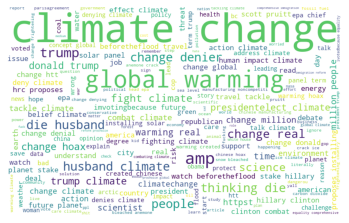

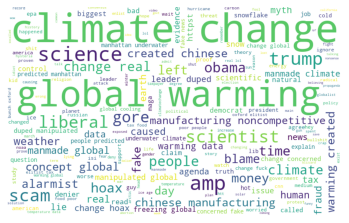

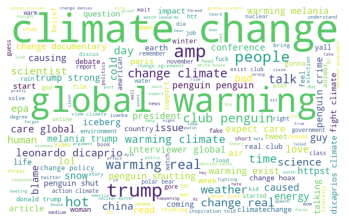

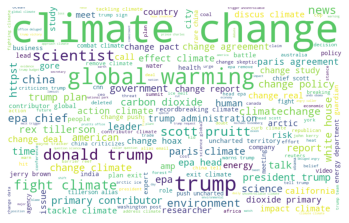

In [20]:
# Collect tweets from the lemmatized_train dataframe written by pro man-made climate change individuals
positive_words = " ".join([sentence for sentence in lemmatized_train['message'][lemmatized_train['sentiment'] == 1]])

# Instantiate  the wordcloud and use positive_words to generate a wordcloud for the 'pro' sentiment
positive_wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                               background_color = 'white').generate(positive_words)

# Plot the positive wordcloud on an empty axis and use plt.show() to display it
ax1 = plt.imshow(positive_wordcloud)
plt.axis('off')
plt.show()

# Collect tweets from the lemmatized_train dataframe written by anti man-made climate change individuals
negative_words = " ".join([sentence for sentence in lemmatized_train['message'][lemmatized_train['sentiment'] == -1]])

# Instantiate the wordcloud  and use negative_words to generate a wordcloud for the anti sentiment
negative_wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                               background_color = 'white').generate(negative_words)

# Plot the negative wordcloud on an empty axis and use plt.show() to display it
ax2 = plt.imshow(negative_wordcloud)
plt.axis('off')
plt.show()

# Collect tweets from the lemmatized_train dataframe written by individuals with neutral views on man-made climate change
neutral_words = " ".join([sentence for sentence in lemmatized_train['message'][lemmatized_train['sentiment'] == 0]])

# Instantiate the wordcloud and use neutral words to generate a wordcloud for the neutral sentiment
neutral_wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                              background_color = 'white').generate(neutral_words)

# Plot the neutral wordcloud on an empty axis and use plt.show() to display it
ax3 = plt.imshow(neutral_wordcloud)
plt.axis('off')
plt.show()

# Collect tweets from the lemmatized_train dataframe that link to actual news stories related to climate change
news_words = " ".join([sentence for sentence in lemmatized_train['message'][lemmatized_train['sentiment'] == 2]])

# Instantiate wordcloud and use news_words to generate a wordcloud for the news
news_wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                           background_color = 'white').generate(news_words)

# Plot the news wordcloud on an empty axis and use plt.show() to display it
ax4 = plt.imshow(news_wordcloud)
plt.axis('off')
plt.show()

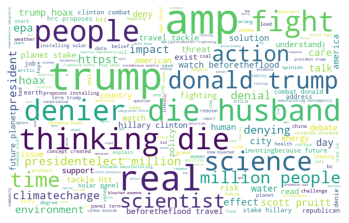

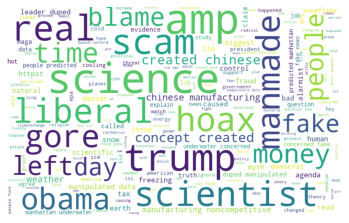

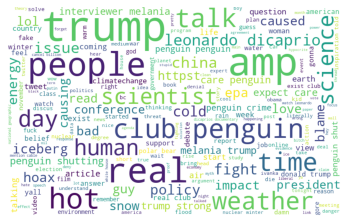

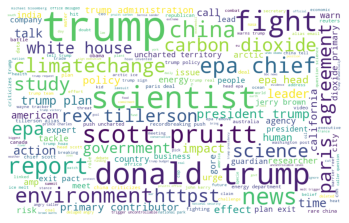

In [21]:
# Create a list of the four most frequent words in the wordclouds
climate_list = ['climate', 'change', 'global', 'warming']

# Collect tweets from positive_words excluding the frequent words from the wordclouds
new_positive = " ".join([word for word in positive_words.split() if word not in climate_list])

# Instantiate  the wordcloud and use positive_words to generate a wordcloud for the 'pro' sentiment
pos_wc = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                   background_color = 'white').generate(new_positive)

# Plot the positive wordcloud on an empty axis and use plt.show() to display it
ax1 = plt.imshow(pos_wc)
plt.axis('off')
plt.show()

# Collect tweets from negative_words excluding the frequent words from the wordclouds
new_negative = " ".join([word for word in negative_words.split() if word not in climate_list])

# Instantiate the wordcloud  and use negative_words to generate a wordcloud for the anti sentiment
neg_wc = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                               background_color = 'white').generate(new_negative)

# Plot the negative wordcloud on an empty axis and use plt.show() to display it
ax2 = plt.imshow(neg_wc)
plt.axis('off')
plt.show()

# Collect tweets from neutral_words excluding the frequent words from the wordclouds
new_neutral = " ".join([word for word in neutral_words.split() if word not in climate_list])

# Instantiate the wordcloud and use neutral words to generate a wordcloud for the neutral sentiment
neu_wc = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                              background_color = 'white').generate(new_neutral)

# Plot the neutral wordcloud on an empty axis and use plt.show() to display it
ax3 = plt.imshow(neu_wc)
plt.axis('off')
plt.show()

# Collect tweets from news_words excluding the frequent words from the wordclouds
new_news = " ".join([word for word in news_words.split() if word not in climate_list])

# Instantiate wordcloud and use news_words to generate a wordcloud for the news
new_wc = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100, 
                           background_color = 'white').generate(new_news)

# Plot the news wordcloud on an empty axis and use plt.show() to display it
ax4 = plt.imshow(new_wc)
plt.axis('off')
plt.show()

In [22]:
# Create function which extracts hashtags from the dataframe
def hashtag_extract(message):
    """The function takes in a tweet and extracts from it twitter hashtags, in the form #hashtag if one is present.
       A regex pattern from the re library is used to find all instances of words starting with the '#' hashtag sign. 
        
        Parameters
        ----------
        message : Pandas Series
            A sentence from which a hashtag will be extracted
            
        Returns
        -------
        Python list of hashtags
        """
    # Create an empty list which will be used to collect hashtags
    hashtags = []
    
    # For every word in message, find words that start with '#' and append them to the empty list
    for tweet in message: # Look through message
        ht = re.findall(r"#(\w+)", tweet) # Use regex pattern to find hashtags
        hashtags.append(ht) # Append the extracted hashtags to the empty list
        
    # Return the created list of hashtags
    return hashtags

In [23]:
# Use the hashtags extract function to get hashtags associated with the positive class from the original training dataframe
positive_hashtags = hashtag_extract(train['message'][train['sentiment'] == 1])

# Use the hashtags extract function to get hashtags associated with the negative class from the original training dataframe
negative_hashtags = hashtag_extract(train['message'][train['sentiment'] == -1])

# Use the hashtags extract function to get hashtags associated with the neutral class from the original training dataframe
neutral_hashtags = hashtag_extract(train['message'][train['sentiment'] == 0])

# Use the hashtags extract function to get hashtags associated with the news class from the original training dataframe
news_hashtags = hashtag_extract(train['message'][train['sentiment'] == 2])

In [24]:
# Create a single list for the positive sentiment
positive_hashtags = sum(positive_hashtags, [])

# Create a single list for the negative sentiment
negative_hashtags = sum(negative_hashtags, [])

# Create a single list for the neutral sentiment
neutral_hashtags = sum(neutral_hashtags, [])

# Create a single list for the news sentiment
news_hashtags = sum(news_hashtags, [])

In [25]:
# Create a distribution plot of the most frequent hashtags in the positive hashtags list 
freq = nltk.FreqDist(positive_hashtags)

# Create a dataframe from the result of the frequency distribution plot, using the hashtags in one column and frequencies
# in a second
df = pd.DataFrame({'Hashtags' : list(freq.keys()),
                   'Count' : list(freq.values())})

# Sort the hashtags by order of descending counts and show the first 10 rows i.e the 10 most frequent hashtags
df_pos = df.sort_values(by = 'Count', ascending = False)
df_pos.head(10)

Hashtags  Count
19           climate    187
24    BeforeTheFlood    129
68     climatechange     94
13   ImVotingBecause     62
4              COP22     59
41    ParisAgreement     50
101     ActOnClimate     42
58                 Ã     37
50             Trump     34
57     IVotedBecause     33

In [26]:
# Create a bar plot using the group dataframe  to visualise the number of tweets per class
fig = go.Figure(go.Bar(x = df_pos['Hashtags'].head(10), 
                       y = df_pos['Count'].head(10).sort_values(ascending = False), # Specify x and y variables
                       marker = {'color': df_pos['Count'],'colorscale': 'viridis'})) # Select a colour for the graph

# Add title, x and y axis labels to the bar chart
fig.update_layout(yaxis_title = 'Hashtag Counts', xaxis_title = 'Hashtags', 
                  title = 'Count of Hashtags for Positive Man-Made Climate Change Sentiment')

# Show the bar plot
fig.show()

In [27]:
# Create a distribution plot of the most frequent hashtags in the negative hashtags list
freq = nltk.FreqDist(negative_hashtags)

# Create a dataframe the results of the frequency distribution plot , using the hashtags in the one column and frequencies
# in a second
df = pd.DataFrame({'Hashtags' : list(freq.keys()),
                   'Count' : list(freq.values())})

# Sort the hashtags by order descending counts and show the first 10 rows i.e the 10 most frequent hashtags
df_neg = df.sort_values(by = 'Count', ascending = False)
df_neg.head(10)

Hashtags  Count
30             MAGA     11
48          climate     10
12            Trump      7
72    climatechange      6
27             tcot      4
52   ParisAgreement      4
7      OpChemtrails      4
108   globalwarming      3
24      ClimateScam      3
13            QandA      3

In [28]:
# Create a bar plot using the group dataframe  to visualise the number of tweets per class
fig = go.Figure(go.Bar(x = df_neg['Hashtags'].head(10), 
                       y = df_neg['Count'].head(10).sort_values(ascending = False), # Specify x and y variables
                       marker = {'color': df_neg['Count'],'colorscale': 'viridis'})) # Select a colour for the graph

# Add title, x and y axis labels to the bar chart
fig.update_layout(yaxis_title = 'Hashtag Counts', xaxis_title = 'Hashtags', 
                  title = 'Count of Hashtags for Negative Man-Made Climate Change Sentiment')

# Show the bar plot
fig.show()

In [29]:
# Create a distribution plot of the most frequent hashtags in neutral hashtags list
freq = nltk.FreqDist(neutral_hashtags)

# Create a dataframe the results of the frequency distribution plot, using the hashtags in the one column and frequencies
# in a second
df = pd.DataFrame({'Hashtags' : list(freq.keys()),
                   'Count' : list(freq.values())})
# Sort the hashtags by order descending counts and show the first 10 rows i.e the 10 most frequent hashtags
df_neu = df.sort_values(by = "Count", ascending = False)
df_neu.head(10)

Hashtags  Count
27          climate     16
104           Trump     11
9     climatechange     11
115  BeforeTheFlood      4
4     ClimateChange      4
70        amreading      4
92            COP22      3
50            QandA      3
78      ParisAccord      3
87         4corners      2

In [30]:
# Create a bar plot using the group dataframe  to visualise the number of tweets per class
fig = go.Figure(go.Bar(x = df_neu['Hashtags'].head(10), 
                       y = df_neu['Count'].head(10).sort_values(ascending = False), # Specify x and y variables
                       marker = {'color': df_neu['Count'],'colorscale': 'viridis'})) # Select a colour for the graph

# Add title, x and y axis labels to the bar chart
fig.update_layout(yaxis_title = 'Hashtag Counts', xaxis_title = 'Hashtags', 
                  title = 'Count of Hashtags for Neutral Man-Made Climate Change Sentiment')

# Show the bar plot
fig.show()

In [31]:
# Create a distribution plot of the most frequent hashtags in news hashtags list
freq = nltk.FreqDist(news_hashtags)

# Create a dataframe the results of the frequency distribution plot, using the hashtags in the one column and frequencies
# in a second
df = pd.DataFrame({'Hashtags' : list(freq.keys()),
                   'Count' : list(freq.values())})

# Sort the hashtags by order descending counts and show the first 10 rows i.e the 10 most frequent hashtags
df_news = df.sort_values(by = 'Count', ascending = False)
df_news.head(10)

Hashtags  Count
0             climate    130
6         environment     44
11      climatechange     42
57              Trump     25
47               news     20
3                  p2     14
142           science     13
10              COP22     13
1       ClimateChange     12
8    GreatBarrierReef     11

In [32]:
# Create a bar plot using the group dataframe  to visualise the number of tweets per class
fig = go.Figure(go.Bar(x = df_news['Hashtags'].head(10), 
                       y = df_news['Count'].head(10), # Specify x and y variables
                       marker = {'color': df_news['Count'],'colorscale': 'viridis'})) # Select a colour for the graph

# Add title, x and y axis labels to the bar chart
fig.update_layout(yaxis_title = 'Hashtag Counts', xaxis_title = 'Hashtags', 
                  title = 'Count of Hashtags for News Climate Change Sentiment')

# Show the bar plot
fig.show()

In [33]:
# Use the clean, preprocessed training data in order to visualise the most frequently use non-stopword words for each sentiment

# Create function to exclude subject matter words such as climate, change, global, and warming
extractor = lambda words:  " ".join([word for word in words.split() if word not in climate_list])

# Extract, from the training dataset, all the tweets written by individuals who were pro man-made climate change
data_pos = lemmatized_train[lemmatized_train['sentiment'] == 1] 
data_pos = data_pos['message'].apply(extractor) # Extract the message column which holds just the tweets in this sentiment

# Extract, from the training dataset, all the tweets written by individuals who were anti man-made climate change
data_neg = lemmatized_train[lemmatized_train['sentiment'] == -1]
data_neg = data_neg['message'].apply(extractor)# Extract the message column which holds just the tweets in this sentiment

# Extract, from the training dataset, all the tweets written by individuals who were neutral on man-made climate change
data_neutral = lemmatized_train[lemmatized_train['sentiment'] == 0]
data_neutral = data_neutral['message'].apply(extractor) # Extract the message column which holds just the tweets in this sentiment

# Extract, from the training dataset, all the tweets related to news about climate change
data_news = lemmatized_train[lemmatized_train['sentiment'] == 2]
data_news = data_news['message'].apply(extractor) # Extract the message column which holds just the tweets in this sentiment

In [34]:
# Instantiate CountVectorizer as cv_pos
cv_pos = CountVectorizer()
docs_pos = cv_pos.fit_transform(data_pos) # Fit cv_pos to the series containing tweets associated with the positive sentiment
features_pos = cv_pos.get_feature_names() # Get the words used in the positive sentiment

# Instantiate CountVectorizer as cv_neg
cv_neg = CountVectorizer()
docs_neg = cv_neg.fit_transform(data_neg) # Fit cv_neg to the series containing tweets associated with the negative sentiment
features_neg = cv_neg.get_feature_names()# Get the words used in the negative sentiment

# Instantiate CountVectorizer as cv_neutral
cv_neutral = CountVectorizer()
# Fit cv_neutral to the series containing tweets associated with the neutral sentiment
docs_neutral = cv_neutral.fit_transform(data_neutral)  
features_neutral = cv_neutral.get_feature_names() # Get words used in the neutral sentiment

# Instantiate CountVectorizer as cv_news
cv_news = CountVectorizer()
docs_news = cv_news.fit_transform(data_news) # Fit cv_news to the series containing tweets associated with the news sentiment
features_news = cv_news.get_feature_names() # Get words used in the negative sentiment

C:\Users\KGOSI\anaconda3\envs\class3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



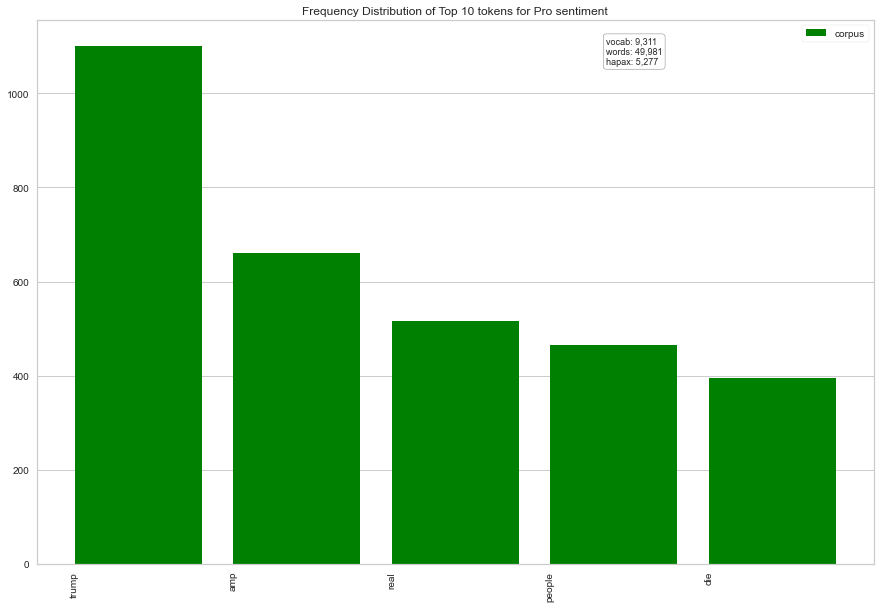

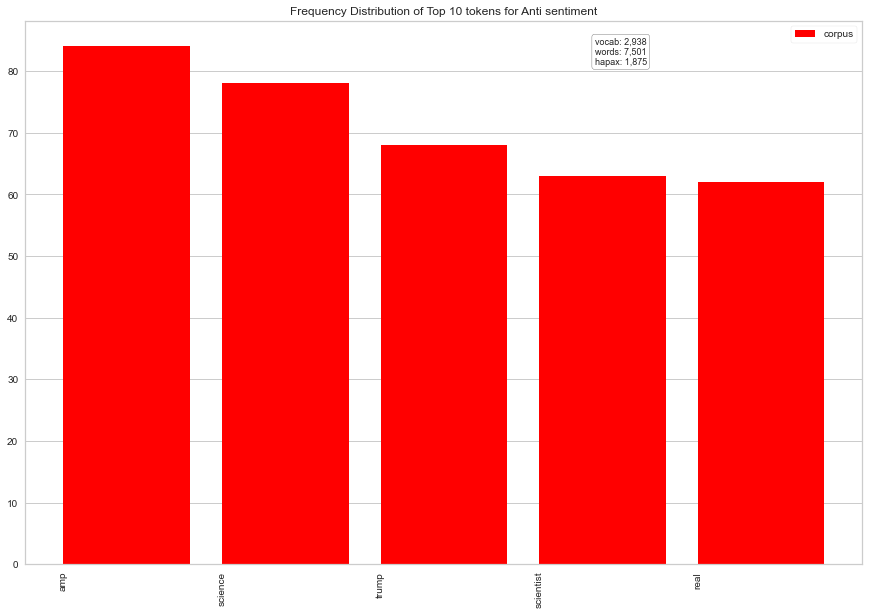

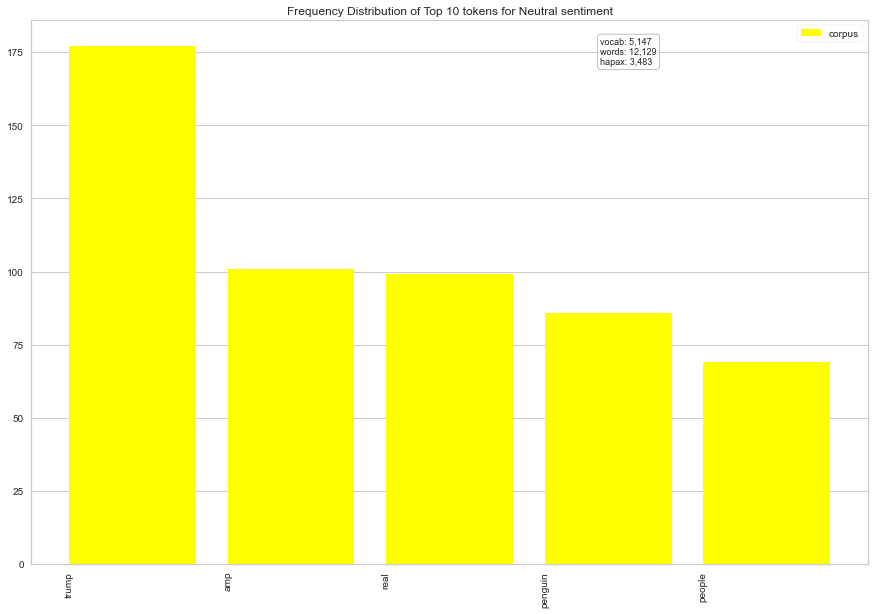

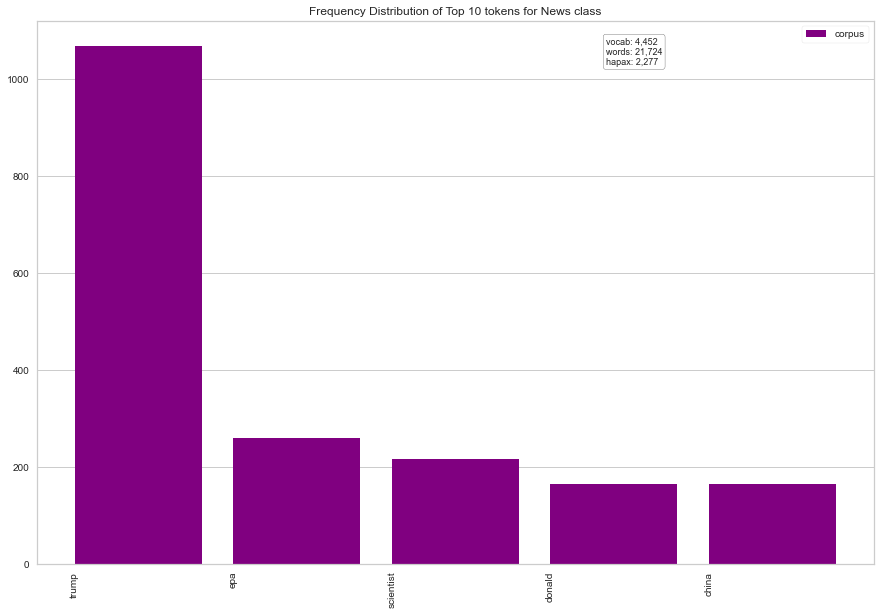

<AxesSubplot:title={'center':'Frequency Distribution of Top 10 tokens for News class'}>

In [35]:
# Create a frequency distribution plot to display the most frequent words associated with the positive sentiment
viz_pos = FreqDistVisualizer(features = features_pos, orient = 'v', n = 5, color = 'green',
                            title = 'Frequency Distribution of Top 10 tokens for Pro sentiment')
#Enlargen the plot
visualizer_pos = RadViz(classes = docs_pos, features = features_pos, size = (1080, 720))

# Fit the vectorized bag of words to the instantiated frequency distribution plot
viz_pos.fit(docs_pos)
viz_pos.show() # Display the graph of positive sentiment words

# Create a frequency distribution plot to display the most frequent words associated with the negative sentiment
viz_neg = FreqDistVisualizer(features = features_neg, orient = 'v', n = 5, color = 'red',
                            title = 'Frequency Distribution of Top 10 tokens for Anti sentiment')
# Enlargen the plot
visualizer_pos = RadViz(classes = docs_pos, features = features_pos, size = (1080, 720))

# Fit the vectorized bag of words to the instantiated frequency distribution plot
viz_neg.fit(docs_neg)
viz_neg.show() # Display the graph of negative sentiment words

# Create a frequency distribution plot to display the most frequent words associated with the neutral sentiment
viz_neutral = FreqDistVisualizer(features = features_neutral, orient = 'v', n = 5, color = 'yellow',
                                title = 'Frequency Distribution of Top 10 tokens for Neutral sentiment')
#Enalargen the plot
visualizer_neutral = RadViz(classes = docs_pos, features = features_pos, size = (1080, 720))

# Fit the vectorized bag of words to the instantiated frequency distribution plot
viz_neutral.fit(docs_neutral)
viz_neutral.show() # Display the graph of neutral sentiment words

# Create a frequency distribution plot to display the most frequent words associated with the news sentiment
viz_news = FreqDistVisualizer(features = features_news, orient = 'v', n = 5, color = 'purple',
                             title = 'Frequency Distribution of Top 10 tokens for News class')
# Enlargen the plot
visualizer_pnews = RadViz(classes = docs_pos, features = features_pos, size = (1080, 720))

# Fit the vectorized bag of words to the instantiated frequency distribution plot
viz_news.fit(docs_news)
viz_news.show() # Display the graph of news sentiment words

In [36]:
# Create a function that cleans the training data and prepares it for modelling
def preprocessing(string):
    """This function takes a sentence and transforms it to lowercase using the lower() string method, it then removed urls,
       numerical values, punctuation, and rts (retweets) using regex patterns.  The function also use TweetTokenizer from the
       nltk.tokenize library in order to remove twitter handles
       
       Parameters
       ----------
       string : str
           A sentence string which is to go through text cleaning
           
       Returns
       -------
       str
           A string which has been cleaned of noise"""
    
    # Change the casing in the inputted string to lowercase
    string = string.lower()
    
    # Remove url addresses from the string
    string = re.sub(r"http\S+", "", string)
    
    # Instantiate TweetTokenizer with an argument that allows for the stripping of twitter handles
    tknzr = TweetTokenizer(strip_handles = True)
    
    # Tokenize the string using TweetTokenizer in order to remove twitter handles
    string = tknzr.tokenize(string)
    
    # Join the tokenized words together into sentences 
    string = " ".join(string)
    
    # Remove punctuation from the string 
    string = re.sub(r'[^a-z0-9\s]', '', string)
    string = re.sub(r'[0-9]+', '', string) # replace numbers or number like words with 'number'
    
    # Remove rt from the string
    message = re.sub(r'^rt', '', string)
    
    # Return a new string which has been cleaned of noise
    return message

In [37]:
# Create a copy our the training data set, train_data, which will be used to build the models
train_data = train.copy()

# Call the created function preprocessing on train_data dataframe message column in order to clear the tweets of noise 
train_data['message']= train_data['message'].apply(preprocessing)

In [38]:
# The label, y, is defined as the sentiment column in the dataframe, train_data
y = train_data.sentiment

# The predictors, X, are defined as the message column in the dataframe, train_data
predictors = train_data.message 

# View the shape of the label and predictors
print(predictors.shape) # predictors
print(y.shape) # label

(15819,)
(15819,)


In [39]:
# Instantiate CountVectorizer with the ngrams argument as cv
cv = CountVectorizer(ngram_range =(1,2))

# Use cv to vectorize the text data in the message columnn of the dataframe, creating a new vector, X
X = cv.fit_transform(predictors)

# View the shape of vectorized the sparse matrix
print("The predictors have the shape:", X.shape)

The predictors have the shape: (15819, 101170)


In [40]:
# Train test split is called on the variables X and y to create a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [41]:
# Print the shape of the X training variable, X_train 
print(f'The X training variable has the shape: {X_train.shape}')

# Print the shape of the y training variable, y_train
print(f'The y training variable has the shape: {y_train.shape}')

# Print the shape of the X validation variable, X_val
print(f'The X validation variable has the shape: {X_val.shape}')

#Print the shape of the y validation variable, y_val
print(f'The y validation variable has the shape: {y_val.shape}')

The X training variable has the shape: (12655, 101170)
The y training variable has the shape: (12655,)
The X validation variable has the shape: (3164, 101170)
The y validation variable has the shape: (3164,)


In [42]:
# Instantiate the Logistic Regression model as logreg
logreg = LogisticRegression(multi_class = 'ovr', solver = 'liblinear', random_state = 42) 

In [43]:
# Fit the model to our training data
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [44]:
# Make predictions on the validation set
y_logreg = logreg.predict(X_val)

In [45]:
# Define the labels to be used in the confusion matrix
true_labels = ['true : Anti', 'true : Neutral', 'true : Pro', 'true : News']
pred_labels = ['pred : Anti', 'pred : Neutral', 'pred : Pro', 'pred : News']
type_labels = ['-1 : Anti', '0 : Neutral', '1 : Pro', '2 : News']

In [46]:
# Create the confusion matrix dataframe to visualise the number of correctly predicted observations
pd.DataFrame(data = confusion_matrix(y_val, y_logreg), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti             114              42         112           10
true : Neutral           15             183         192           35
true : Pro               16              66        1543          130
true : News               4              13         148          541

In [47]:
# Create a classification report from the validation set
logreg_report = classification_report(y_val, y_logreg, target_names=type_labels)

# Print out the classification report 
print(logreg_report)

              precision    recall  f1-score   support

   -1 : Anti       0.77      0.41      0.53       278
 0 : Neutral       0.60      0.43      0.50       425
     1 : Pro       0.77      0.88      0.82      1755
    2 : News       0.76      0.77      0.76       706

    accuracy                           0.75      3164
   macro avg       0.72      0.62      0.65      3164
weighted avg       0.75      0.75      0.74      3164



In [48]:
f1_score_logreg = f1_score(y_val,y_logreg,average ="weighted") 
print(f'This is the accuracy for the basic LogisticRegression classifier: {f1_score_logreg}')

This is the accuracy for the basic LogisticRegression classifier: 0.7405999576244999


In [49]:
# Instantiate SMOTE as sm
sm = SMOTE(random_state = 42) 

In [50]:
# Fit the SMOTE model on the training data
X_res, y_res = sm.fit_resample(X_train, y_train) 

In [51]:
# Instantiate a Logistic Regression model to use with the resampled data as logreg_smote 
logreg_smote = LogisticRegression(multi_class = 'ovr', solver = 'liblinear', random_state = 42)

In [52]:
# Fit the logistic regression model on the resampled data
logreg_smote.fit(X_res, y_res)

LogisticRegression(multi_class='ovr', random_state=42, solver='liblinear')

In [53]:
# Predict on the validation set
y_logreg_smote = logreg_smote.predict(X_val)

In [54]:
# Create a confusion matrix on the validation data
pd.DataFrame(data = confusion_matrix(y_val, y_logreg_smote), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti             145              39          80           14
true : Neutral           58             182         140           45
true : Pro               71             105        1409          170
true : News              17              24          91          574

In [55]:
# classification report on the validation set
smote_report = classification_report(y_val, y_logreg_smote, target_names = type_labels)

# Print the classification report
print(smote_report)

              precision    recall  f1-score   support

   -1 : Anti       0.50      0.52      0.51       278
 0 : Neutral       0.52      0.43      0.47       425
     1 : Pro       0.82      0.80      0.81      1755
    2 : News       0.71      0.81      0.76       706

    accuracy                           0.73      3164
   macro avg       0.64      0.64      0.64      3164
weighted avg       0.73      0.73      0.73      3164



In [56]:
# Calcuate the f1 score on the validation set
f1_score_logreg_smote = f1_score(y_val, y_logreg_smote, average = "weighted")

# Print the f1 score
print(f'This is the accuracy for the basic LogisticRegression classifier: {f1_score_logreg_smote}')

This is the accuracy for the basic LogisticRegression classifier: 0.7274317818071886


In [57]:
# Create a dataframe to show the f1 scores of the basic logistic regression model vs the smote logistic regression model

# Create a list of f1 scores
f1_scores = [f1_score_logreg, f1_score_logreg_smote]

# Create a list to use as row labels
models = ["logreg(no smote)","logreg(with smote)"] 

# Create metric column name list
metrics = ['f1_score']

# Create the dataframe
model_df = pd.DataFrame(data = f1_scores, index = models, columns = metrics)

# Display the first 5 rows of the new dataframe
model_df.head()

f1_score
logreg(no smote)    0.740600
logreg(with smote)  0.727432

In [58]:
# Instantiate the support vector classifier model as svm_clf 
svm_clf = SVC(C = 10, gamma = 0.01)

In [59]:
# Fit the model on the training data
svm_clf.fit(X_train, y_train)

SVC(C=10, gamma=0.01)

In [60]:
# Predict on the validation set
y_svm_CV = svm_clf.predict(X_val)

In [61]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, y_svm_CV), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti             119              43         110            6
true : Neutral           16             193         193           23
true : Pro               16              77        1535          127
true : News               2              22         127          555

In [62]:
# Print the classification report the validation set
print(classification_report(y_val, y_svm_CV, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.78      0.43      0.55       278
 0 : Neutral       0.58      0.45      0.51       425
     1 : Pro       0.78      0.87      0.83      1755
    2 : News       0.78      0.79      0.78       706

    accuracy                           0.76      3164
   macro avg       0.73      0.64      0.67      3164
weighted avg       0.75      0.76      0.75      3164



In [63]:
# Calculate the f1 score on the validation set
f1_score_svm = f1_score(y_val, y_svm_CV, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the basic Support Vector Machine classifier: {f1_score_svm}')

This is the accuracy for the basic Support Vector Machine classifier: 0.7492909088603493


In [64]:
# Instantiate a support vector classifier model to use on the resampled data
svm_clf_CV_smote = SVC(C = 10, gamma = 0.01)

# Fit the model on the resampled data
svm_clf_CV_smote.fit(X_res,y_res)

SVC(C=10, gamma=0.01)

In [65]:
# Predict using the validation set
y_pred_svm_CV_smote = svm_clf_CV_smote.predict(X_val)

In [66]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, y_pred_svm_CV_smote), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti             127              36         110            5
true : Neutral           47             167         189           22
true : Pro               56              88        1486          125
true : News              19              40         118          529

In [67]:
# Print the classification report the validation set
print(classification_report(y_val, y_pred_svm_CV_smote, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.51      0.46      0.48       278
 0 : Neutral       0.50      0.39      0.44       425
     1 : Pro       0.78      0.85      0.81      1755
    2 : News       0.78      0.75      0.76       706

    accuracy                           0.73      3164
   macro avg       0.64      0.61      0.62      3164
weighted avg       0.72      0.73      0.72      3164



In [68]:
# Calculate the f1 score on the validation set
f1_svm_CV_smote = f1_score(y_val, y_pred_svm_CV_smote, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the basic Support Vector Machine classifier: {f1_score_svm}')

This is the accuracy for the basic Support Vector Machine classifier: 0.7492909088603493


In [69]:
# Create a dataframe to show the f1 scores of the basic support vector classifier model vs the smote support vector classifier
# model

# Create a list of f1 scores
f1_scores = [f1_score_svm, f1_svm_CV_smote]

# Create a list to use as row labels
models = ["svc(no smote)","svc(with smote)"] 

# Create metric column name list
metrics = ['f1_score']

# Create the dataframe
model_df = pd.DataFrame(data = f1_scores, index = models, columns = metrics)

# Display the first 5 rows of the new dataframe
model_df.head()

f1_score
svc(no smote)    0.749291
svc(with smote)  0.722556

In [70]:
# Instantiate the naive bayes model as nb
nb = MultinomialNB() 

In [71]:
# Fit the model on the training data
nb.fit(X_train, y_train)

MultinomialNB()

In [72]:
# Predict on the validation data
pred_nb = nb.predict(X_val)

In [73]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, pred_nb), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti              63              44         160           11
true : Neutral            6             142         232           45
true : Pro                5              57        1535          158
true : News               2               8         151          545

In [74]:
# Print the classification on the validation set
print(classification_report(y_val, pred_nb, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.83      0.23      0.36       278
 0 : Neutral       0.57      0.33      0.42       425
     1 : Pro       0.74      0.87      0.80      1755
    2 : News       0.72      0.77      0.74       706

    accuracy                           0.72      3164
   macro avg       0.71      0.55      0.58      3164
weighted avg       0.72      0.72      0.70      3164



In [75]:
# Calculate the f1 score on the validation set
f1_nb = f1_score(y_val, pred_nb, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the Naive Bayes classifier: {f1_score_svm}')

This is the accuracy for the Naive Bayes classifier: 0.7492909088603493


In [76]:
# Instantiate the naive bayes classifier as nb_smote to use on the resampled data
nb_smote = MultinomialNB()

In [77]:
# Fit the model on the resampled data
nb_smote.fit(X_res, y_res)

MultinomialNB()

In [78]:
# Predict of the validation set
pred_nbsmote = nb_smote.predict(X_val)

In [79]:
# Create a dataframe to display the confusion matrix results
pd.DataFrame(data = confusion_matrix(y_val, pred_nbsmote), index = true_labels, columns = pred_labels)

pred : Anti  pred : Neutral  pred : Pro  pred : News
true : Anti             136              43          86           13
true : Neutral           49             177         149           50
true : Pro               74             127        1343          211
true : News              18              18          89          581

In [80]:
# Print the classification report of the validation set
print(classification_report(y_val, pred_nbsmote, target_names = type_labels))

              precision    recall  f1-score   support

   -1 : Anti       0.49      0.49      0.49       278
 0 : Neutral       0.48      0.42      0.45       425
     1 : Pro       0.81      0.77      0.78      1755
    2 : News       0.68      0.82      0.74       706

    accuracy                           0.71      3164
   macro avg       0.62      0.62      0.62      3164
weighted avg       0.71      0.71      0.70      3164



In [81]:
# Calculate the f1 score on the validation set
f1_nb_smote = f1_score(y_val, pred_nbsmote, average = "weighted") 

# Print the f1 score
print(f'This is the accuracy for the Naive Bayes classifier: {f1_score_svm}')

This is the accuracy for the Naive Bayes classifier: 0.7492909088603493


In [82]:
# Create a dataframe to show the f1 scores of the Naive Bayes classifier model vs the smote Naive Bayes classifier
# model

# Create a list of f1 scores
f1_scores = [f1_nb, f1_nb_smote]

# Create a list to use as row labels
models = ["NB (no smote)","NB (with smote)"] 

# Create metric column name list
metrics = ['f1_score']

# Create the dataframe
model_df = pd.DataFrame(data = f1_scores, index = models, columns = metrics)

# Display the first 5 rows of the new dataframe
model_df.head()

f1_score
NB (no smote)    0.697987
NB (with smote)  0.704730

In [83]:
# define classifiers that we'll apply cross validation to
clf1 = logreg
clf2 = svm_clf
clf3 = nb

# create empty list where we'll append the f1 score's mean and std of each classifier obtained through cross validation
cross_val = []

# loop through list of classifiers and apply cross_val_score function
for clf, label in zip([clf1,clf2,clf3],['Logistic Regresion','SVM', 'Naive Bayes']):
    print(label)
    scores = cross_val_score(clf, X, y, cv=5, scoring = 'f1_micro')
    print("f1 score: {:0.4f} (+/- {:0.4f})".format(scores.mean(), scores.std()))
    cross_val.append([label, scores.mean(), scores.std() ]) # append the scores to the empty list created above

Logistic Regresion
f1 score: 0.7450 (+/- 0.0043)
SVM
f1 score: 0.7432 (+/- 0.0024)
Naive Bayes
f1 score: 0.7116 (+/- 0.0014)


In [84]:
# convert list of cv scores to dataframe
cross_val = pd.DataFrame(cross_val, columns=['Model', 'CV_Mean', 'CV_Std_Dev'])
cross_val.set_index('Model', inplace=True) # set index to the name of model

In [85]:
# view our dataframe containing cross valiation mean and std
cross_val

CV_Mean  CV_Std_Dev
Model                                   
Logistic Regresion  0.744990    0.004258
SVM                 0.743157    0.002380
Naive Bayes         0.711612    0.001393

In [86]:
# Create a copy of the test to perform noise cleaning and vectorization on
test_data = test.copy()

In [87]:
# Call the data cleaning function the test_data dataframe to remove noise in preparation for cleaning
test_data['message'] = test_data['message'].apply(preprocessing)

In [88]:
# Use CountVector in order to encode the words in the clean test dataframe
test_cv_trans =  cv.transform(test_data['message'])

# Print out the shape of the newly vectorized dataframe
print("The shape of the data is:", test_cv_trans.shape)

The shape of the data is: (10546, 101170)


In [89]:
# predict on test_data
y_pred_logreg_sub = logreg.predict(test_cv_trans)

In [90]:
# Extract the tweetid column from test_data to use as the submission file index
tweetid = test_data['tweetid']

In [91]:
# Create a dataframe using the test_data tweetid and and the predicted sentiment
submission_logreg = pd.DataFrame({'tweetid' : tweetid, 'sentiment' : y_pred_logreg_sub})

In [92]:
# Display the last 5 rows of the submission file
submission_logreg.tail()

tweetid  sentiment
10541   895714          1
10542   875167          1
10543    78329          2
10544   867455          0
10545   470892          1

In [93]:
# Save dataframe to a csv file for submission
submission_logreg.to_csv("Kgosietsile_Cele_AC_Climate.csv", index = False)

In [94]:
# predict on test_data
y_pred_svm_sub = svm_clf.predict(test_cv_trans)

In [95]:
# Create a dataframe using the test_data tweetid and and the predicted sentiment
submission_svc = pd.DataFrame({'tweetid' : tweetid, 'sentiment' : y_pred_svm_sub})

In [96]:
# Display the last 5 rows of the submission file
submission_svc.tail()

tweetid  sentiment
10541   895714          1
10542   875167          1
10543    78329          0
10544   867455          0
10545   470892          1

In [97]:
# Save dataframe to a csv file for submission
submission_svc.to_csv("Kgosietsile_Cele_AC_Climate.csv", index = False)

In [98]:
y_pred_nb = nb.predict(test_cv_trans)

In [99]:
# Create a dataframe using the test_data tweetid and and the predicted sentiment
submission_nb = pd.DataFrame({'tweetid' : tweetid, 'sentiment' : y_pred_nb})

In [100]:
# Display the last 5 rows of the submission file
submission_nb.tail()

tweetid  sentiment
10541   895714          1
10542   875167          1
10543    78329          1
10544   867455          0
10545   470892          1

In [101]:
# Save dataframe to a csv file for submission
submission_nb.to_csv("Kgosietsile_Cele_AC_Climate.csv", index = False)